<p style="margin-top: 22px; font-size:40px; text-align: center;  
font-weight: bold;  line-height: 100%;">
    CookHLA on OAS server
</p>

# Goal of task

Imputation of HLA region.

KCHIP_HLA(159MB, n=125,872, markers=5,292)


=>china_pan(256MB, n=10,521, markers=6,354)

(n과 markers는 .fam과 .bim의 라인수입니다.)

# Computing nodes in OAS server

* o2-big01: 24core, 160G x 1node
* o2-big02: 36core, 760G x 1node
* o2-com**: 12core, 50G x 30nodes

o2-big02 node가 성능이 가장 좋습니다.

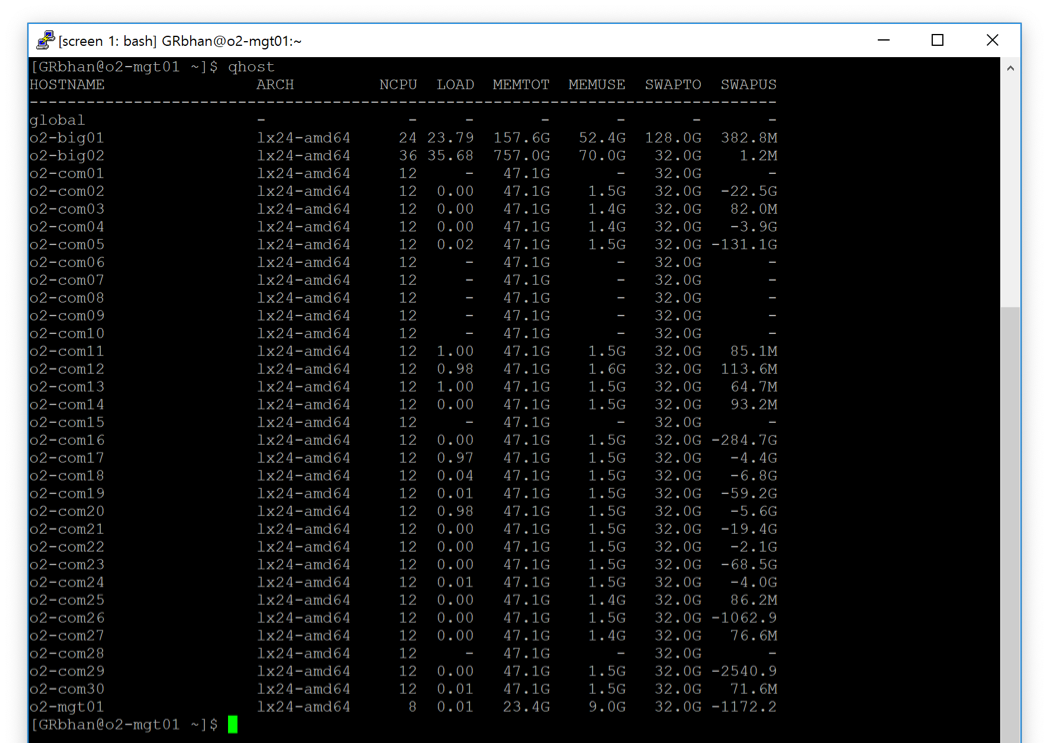

# First Trial (Failure) 2019.04.10


맨 처음에 OAS서버가 클러스터 구조인지 모르고, qsub를 사용하지 않고 접속 node에서 실행시켰을 때의 결과입니다.
* 시도1
n=125,872(샘플 모두), java memory size=10,000MB <br>
beagle4.1 imputation단계에서 java.lang.OutOfMemoryError: Java heap space 에러가 발생하여 halt되었습니다.

* 시도2
n=125,872(샘플 모두), java memory size=20,000MB <br>
imputation 단계 진입 후 10분 정도 뒤에, 아래 사진처럼 memory bottleneck로 추정되는 현상이 일어났습니다. <br>
physical memory free space가 적고, CPU usage가 12.5%에서(OAS=8core) 1~2% 로 떨어졌습니다. <br>
이 상태로는 완료가 거의 불가할 것이라고 판단했습니다.

이후 qsub로 실행해야한다는 사실을 깨달았으나, qsub 오류를 발견하습니다.


`"can't get password entry for user "GRbhan". Either the user does not exist or NIS error!"`

OAS쪽에 요청하였고 답변을 받는 약 한달간 잠시 프로젝트 진행을 중지했습니다. (4.12~5.4)


# Second Trial (Failure) 2019.05.04


```
qrsh -l h='o2-big02'
cd CookHLA
./CookHLA.csh KCHIP_HLA china_pan_hg19_reference result0410_ ./plink result0410.genetic.map result0410.aver.erate 500000
```
o2-big02 노드의 메모리 사이즈가 760GB입니다.
어느정도의 메모리가 필요할지 감이 잡히지 않아, 충분히 resource를 이용하고자,
Java heap size 파라미터로 500GB를 사용하였습니다. (java 커맨드의 Xmx 파라미터에 전달됩니다.)

그러나, 안타깝게 11번째 iteration에서 더 이상 진척이 없는 현상이 발생하였습니다. (Beagle은 15 iterations에 걸쳐 imputation을 진행합니다.)
처음 CookHLA command실행후 20일이 지났으나 아직 변화가 없습니다. 1~10번째 iteration은 6~8시간이면 완료되었습니다. 11번째 iteration부터 phasing iteration이 시작하는데, 다른 iteration에 비해 computationally 버거운 것 같습니다.


5. Third Trial(Success)의 log를 참고해보면, 11~15iter가 1~10iter보다 10배정도 오래걸립니다. 이 비율에 따르면, 80시간(4일)이면 끝나야하는데, 이보다 훨씬 오래걸리고 있습니다. 아마 Beagle의 구조가 computing resource를 잘 이용하지 못하고 있는 것이 아닌가하는 의심이 듭니다.

## log
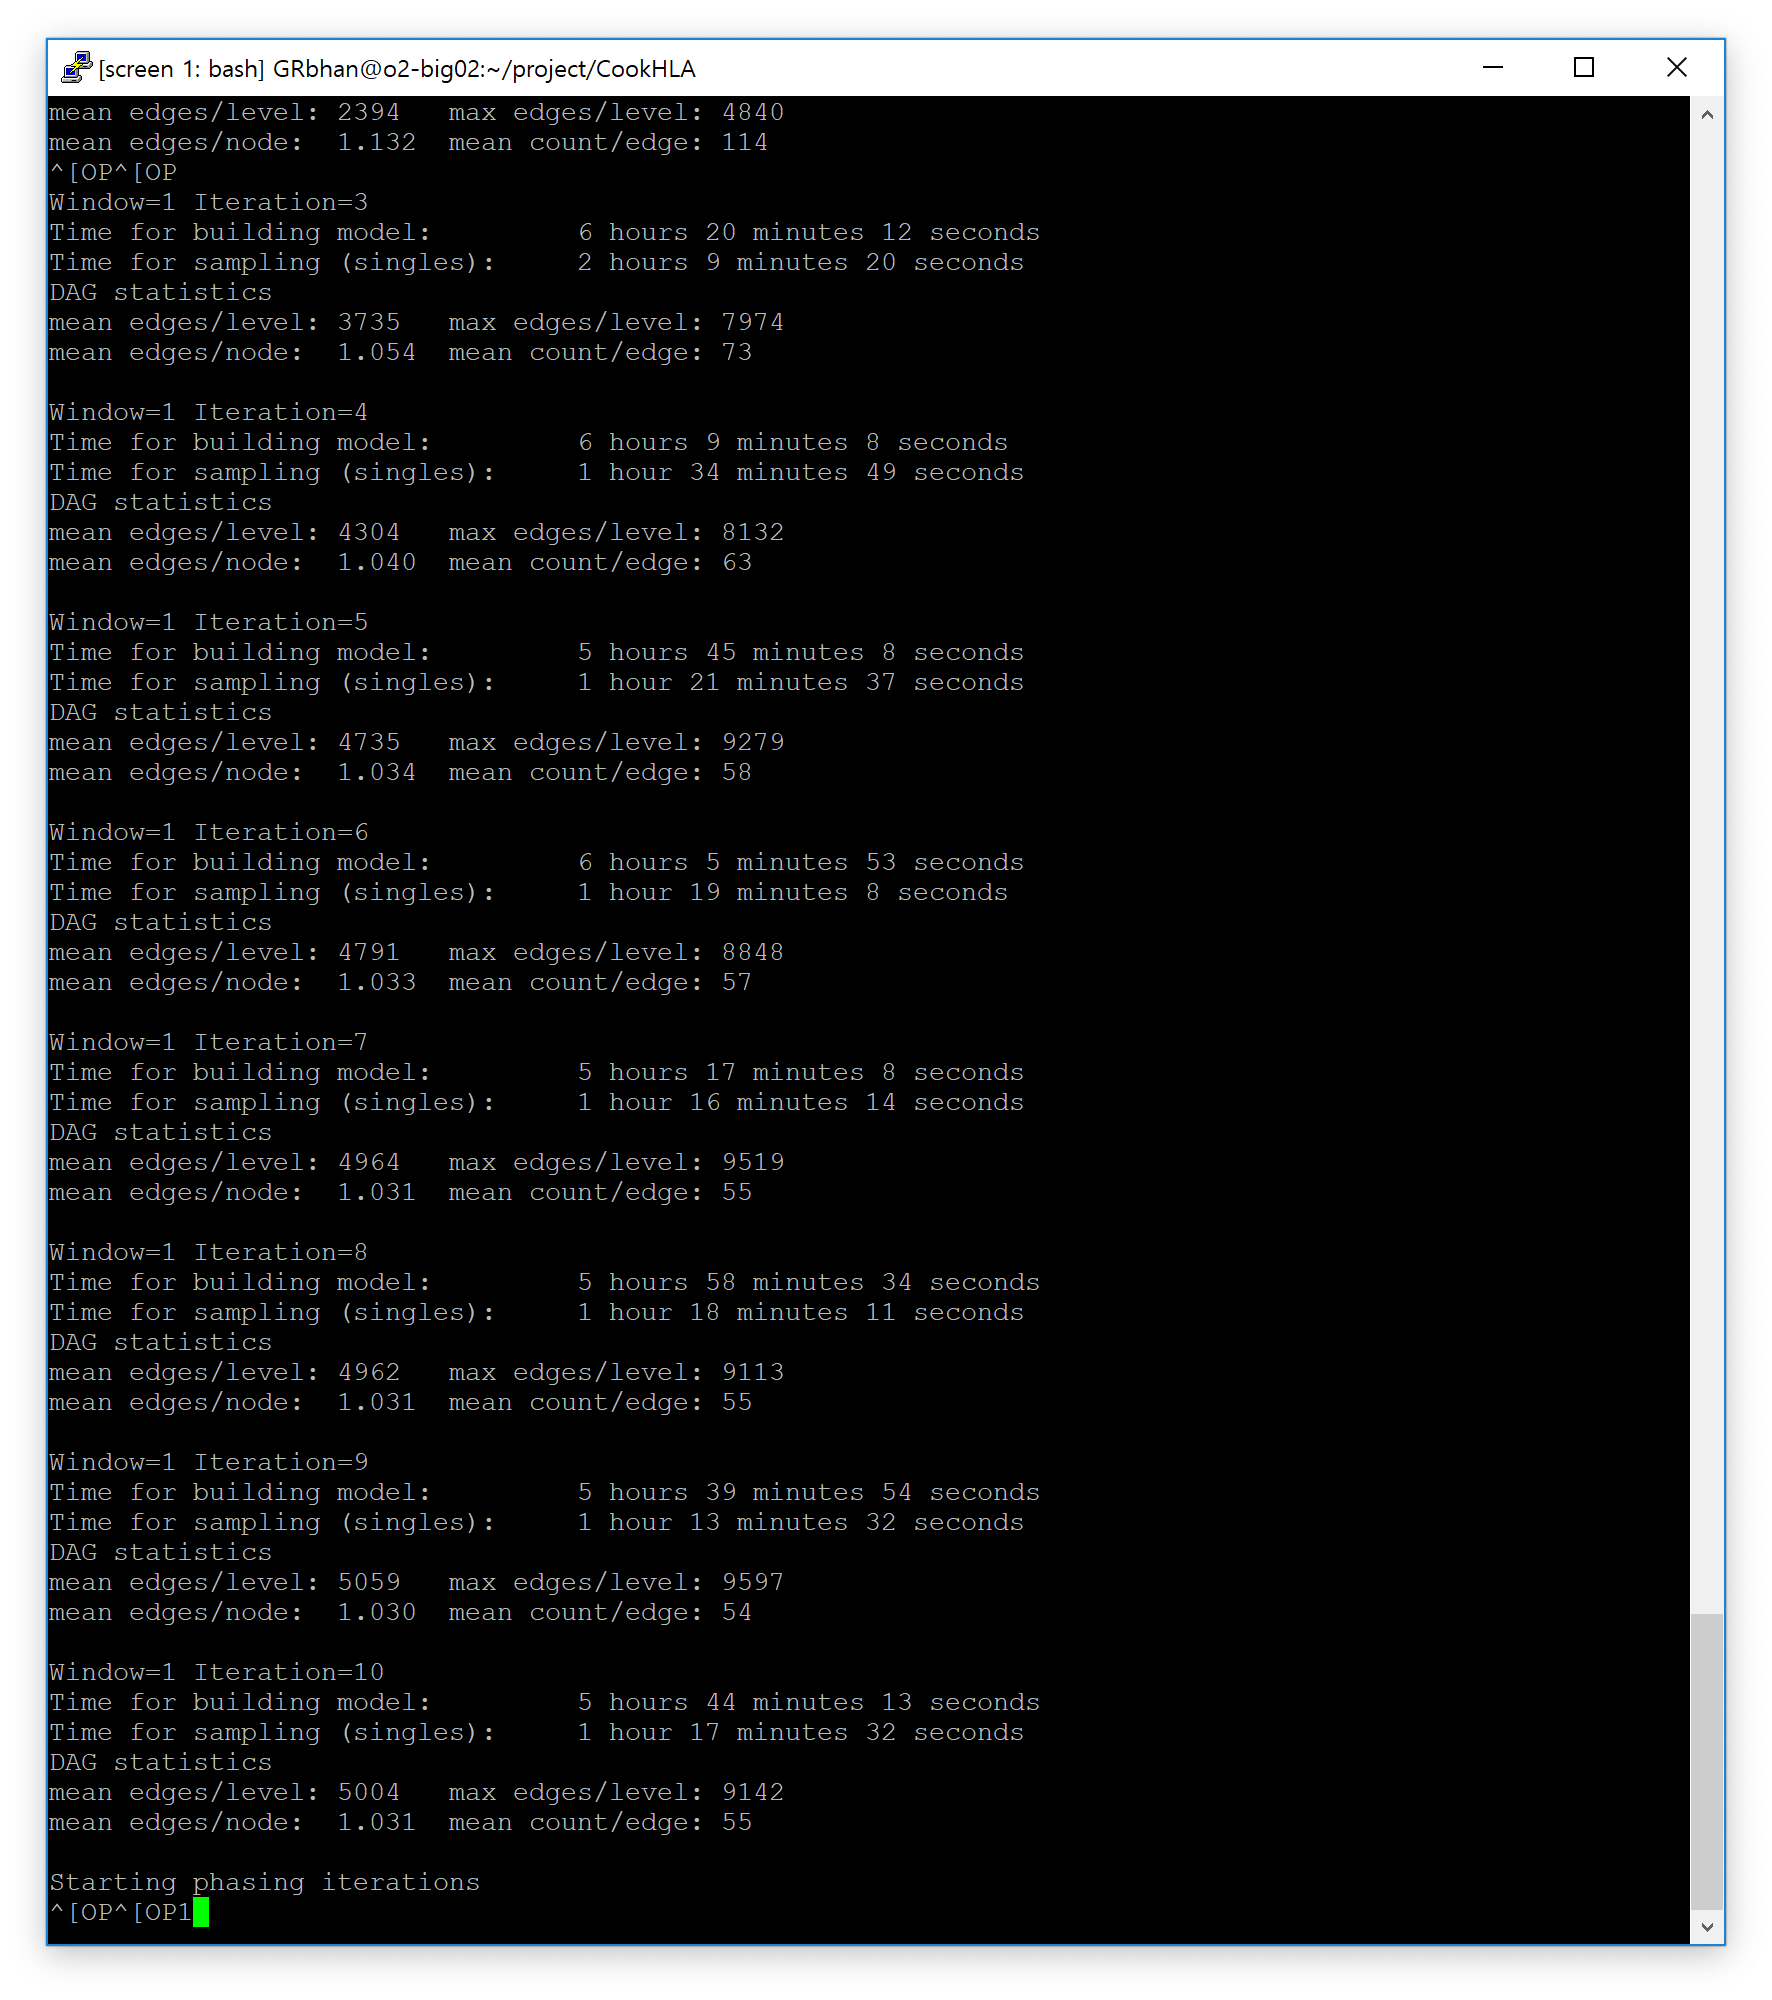

## top
beagle java 프로세스의 CPU 사용률이 3600%로 resource를 잘 이용하고 있는 것 처럼 보이기는 합니다.
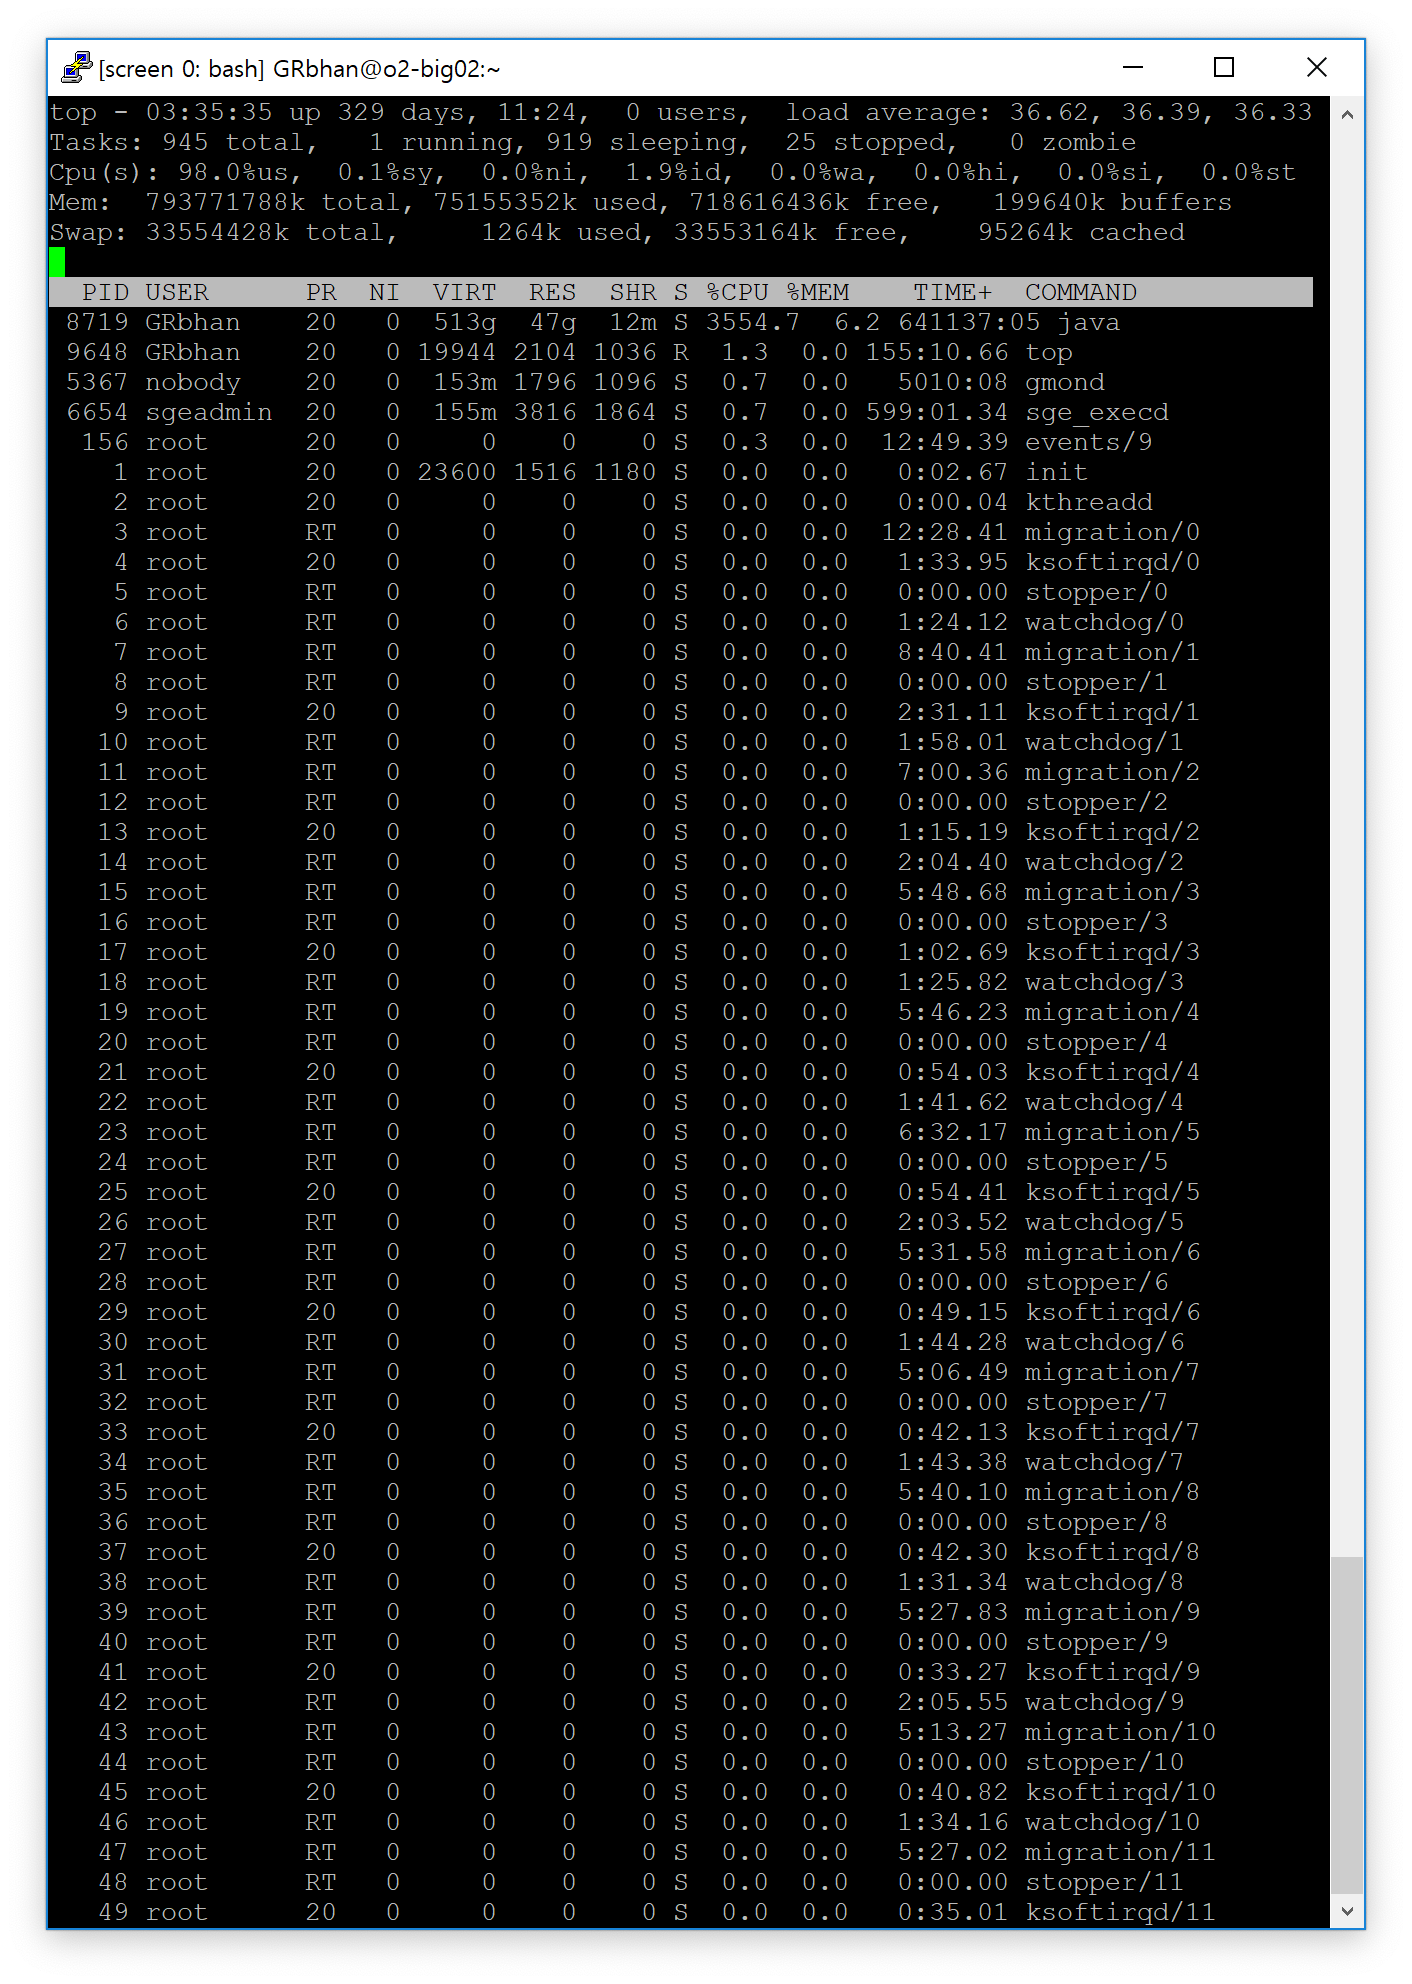

# Third Trial(Success) - Alternative: Subsampling target genotype data (KCHIP_HLA) 2019.05.21

대안으로, 125,872 individuals을 10,000명씩 나눠서 CookHLA를 진행하였습니다.<br>
단순히 plink의 --keep argument를 사용하여 KCHIP_HLA(.bim,.bed,.fam)를 split하였습니다.<br>
CookHLA실행전 준비단계로 MakeGeneticMap.csh를 사용하여 genetic.map과 aver.erate을 만드는데,<br>
이 파일들은 모든 subsample에 대해 동일한 파일을 사용하였습니다.

아래는 1~13개의 subsample 중 1번째 set으로 CookHLA를 진행하는 shell script입니다.

o2-big01 ,o2-com01부터 o2-com12까지 subsample별로 deploy하였습니다.<br>
OAS서버에 노드가 많은데 이용자가 거의 없어, OAS서버의 computing power을 충분히 잘 사용할 수 있었습니다.<br>
노드별로 50GB의 메모리가 있기 때문에, 메모리 파라미터로 50GB를 주었습니다.<br>
(예외적으로 o2-big01은 160GB의 메모리가 있어서, 메모리 파라미터 100GB를 주었습니다.)

```
qrsh -l h='o2-com01'
R -q -e "a=read.table('KCHIP_HLA.fam');write.table(a[1:10000,],'KCHIP_HLA.fam.sub13',sep=' ',row.names=FALSE,col.names=FALSE,quote=FALSE)"
./plink --bfile KCHIP_HLA --keep KCHIP_HLA.fam.sub01 --make-bed --out KCHIP_HLA_sub01 --noweb
./CookHLA.csh KCHIP_HLA_sub01 china_pan_hg19_reference IMP0521_01 ./plink geneticmap0521.genetic.map geneticmap0521.aver.erate 50000
```

## log
<a id='another_cell'></a>
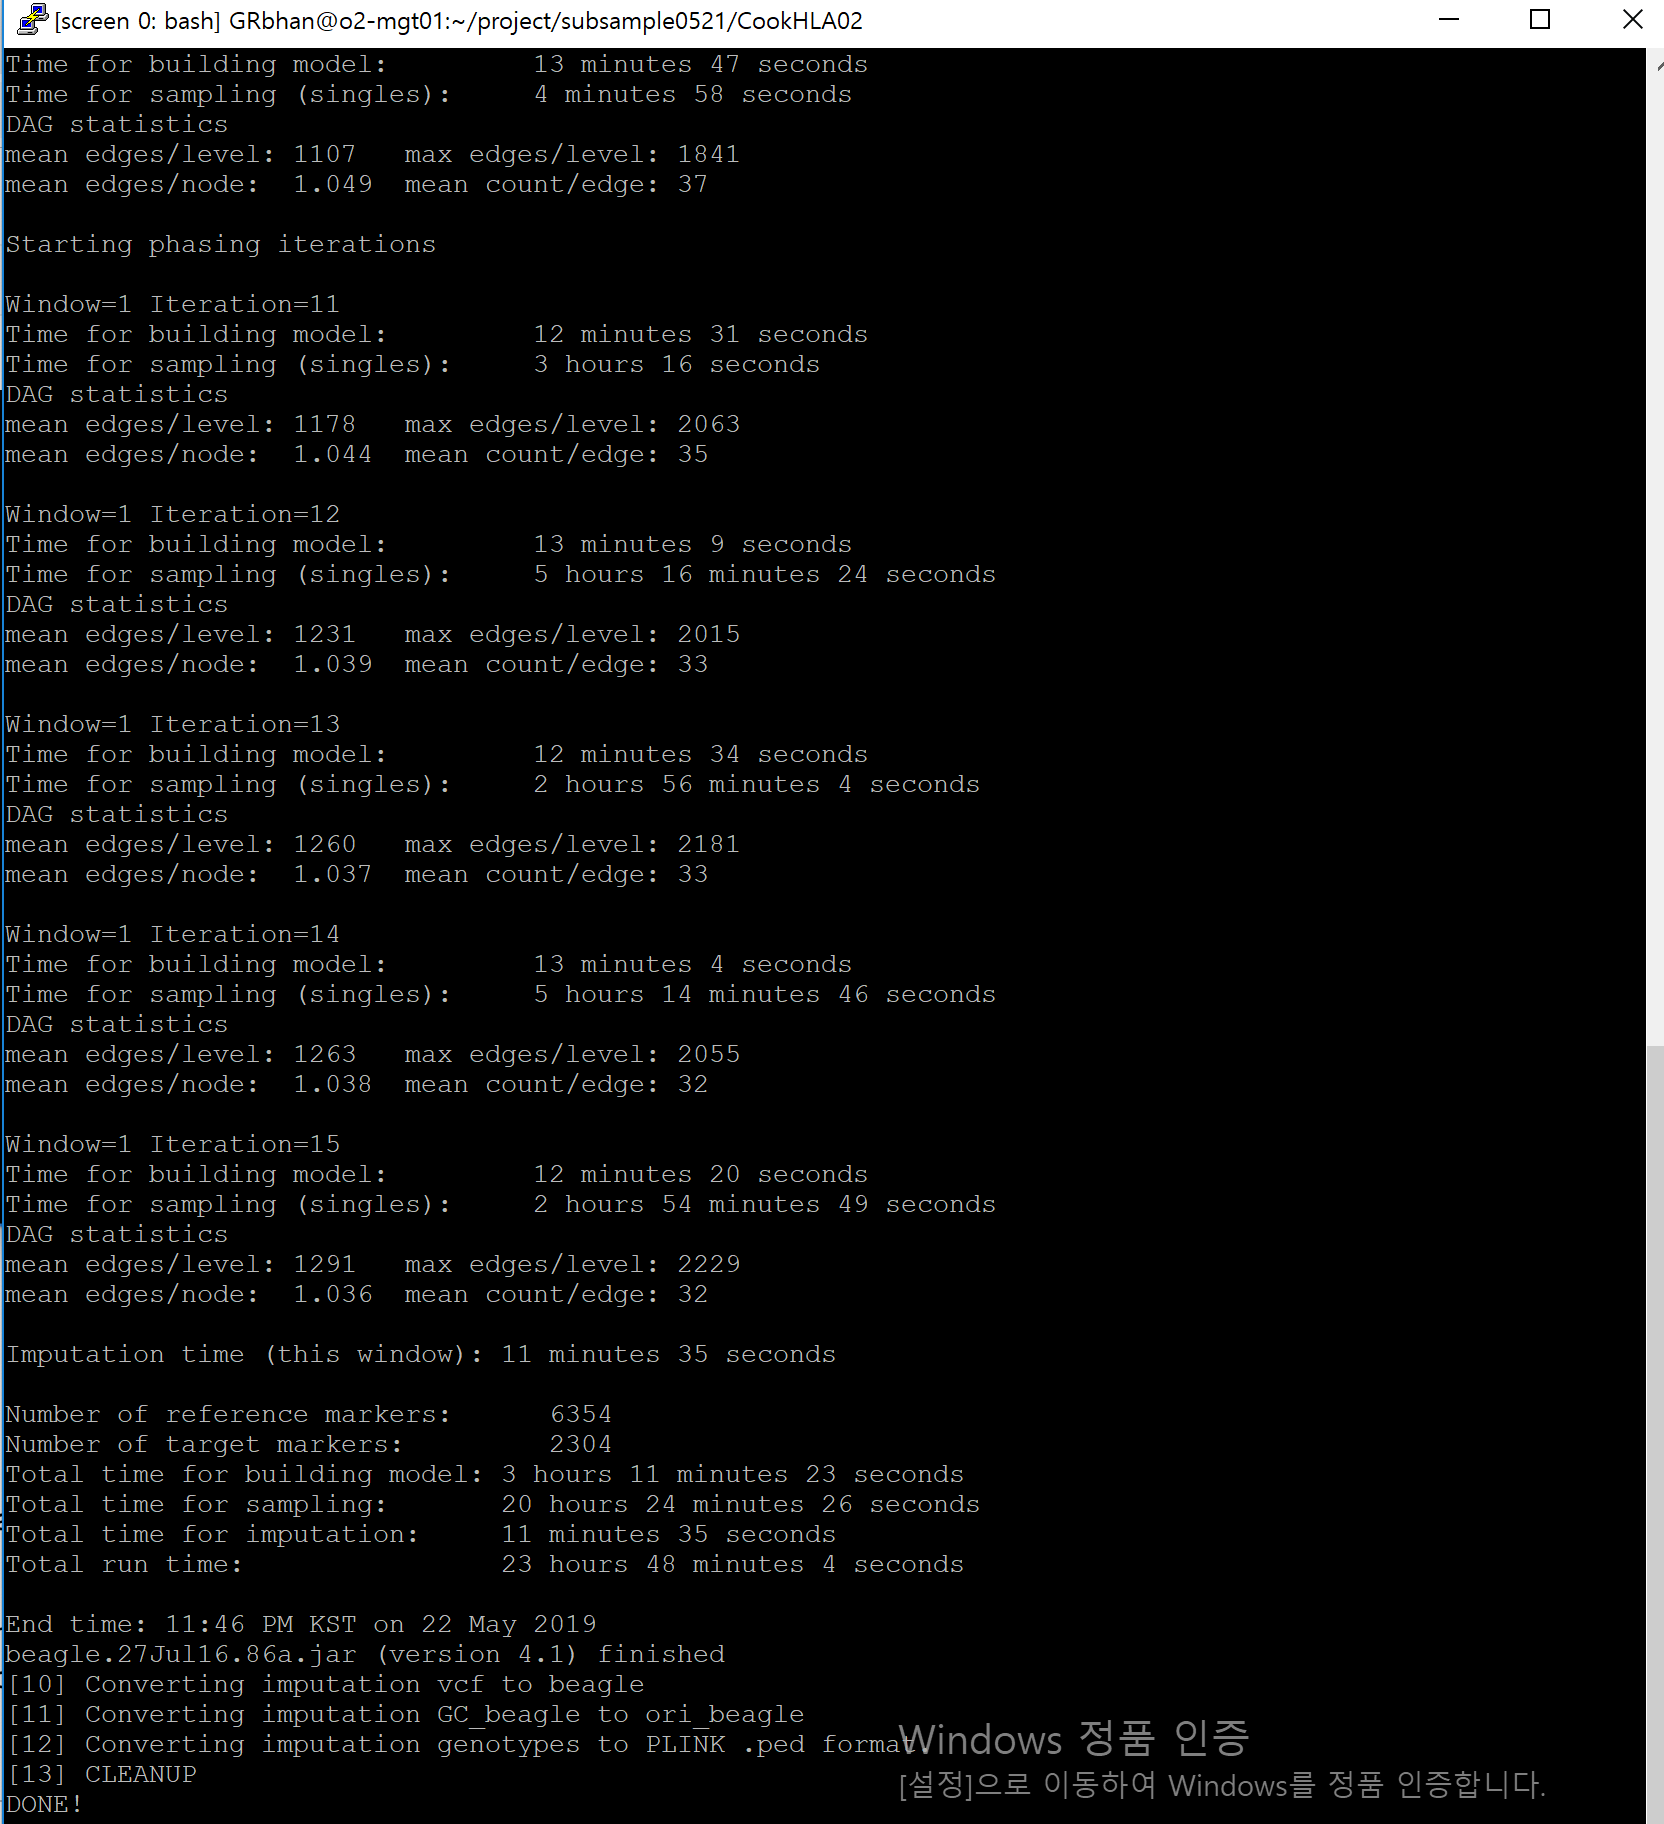

## top

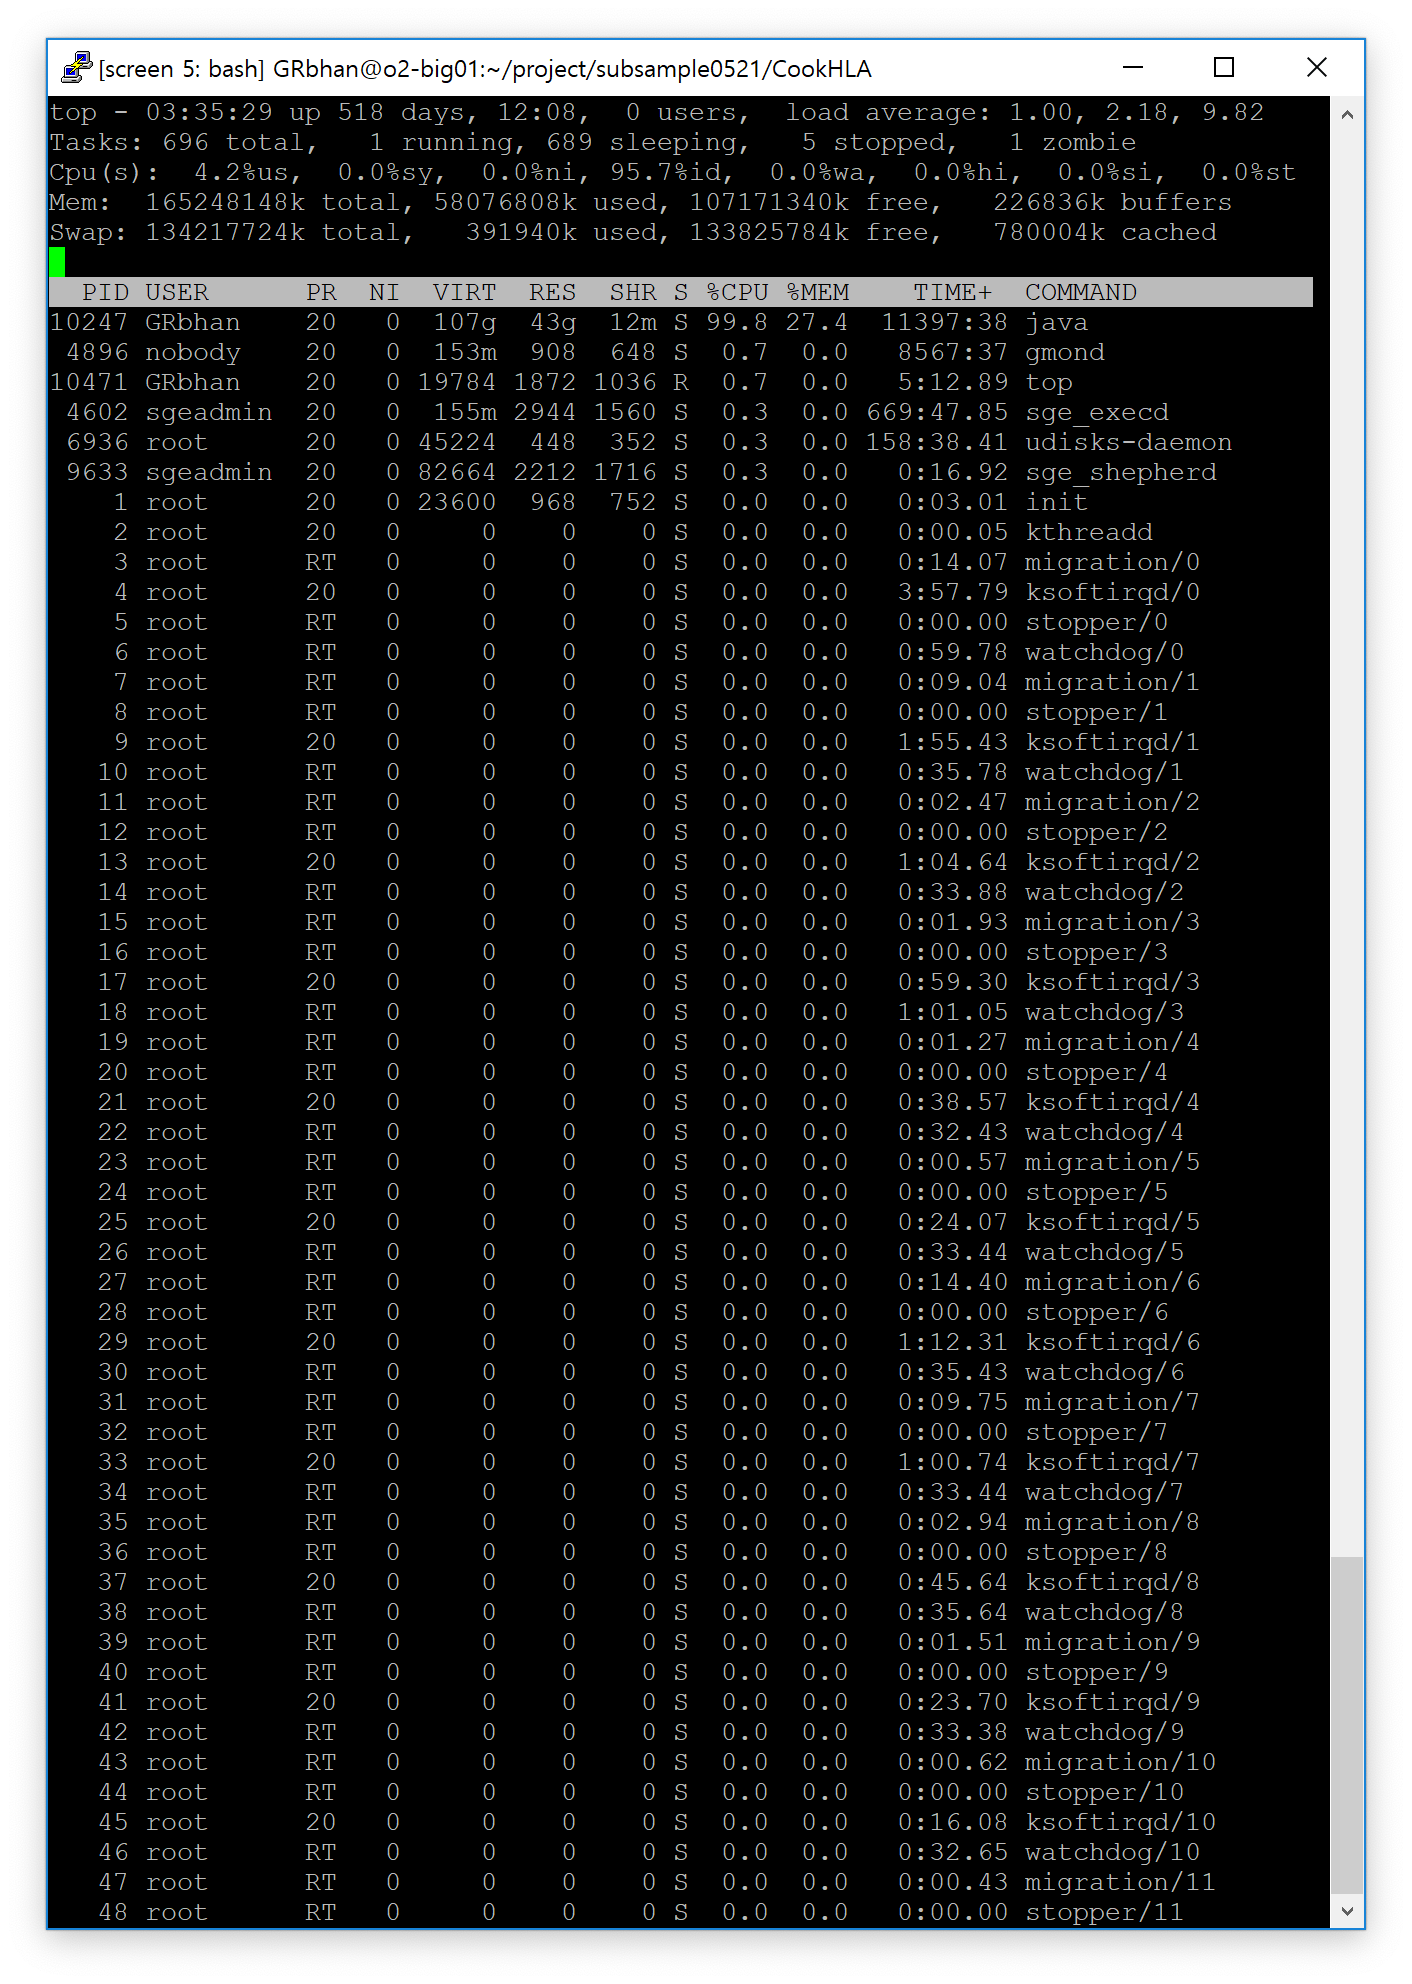

## Files

### Directory of 1st subsample (/CookHLA01)
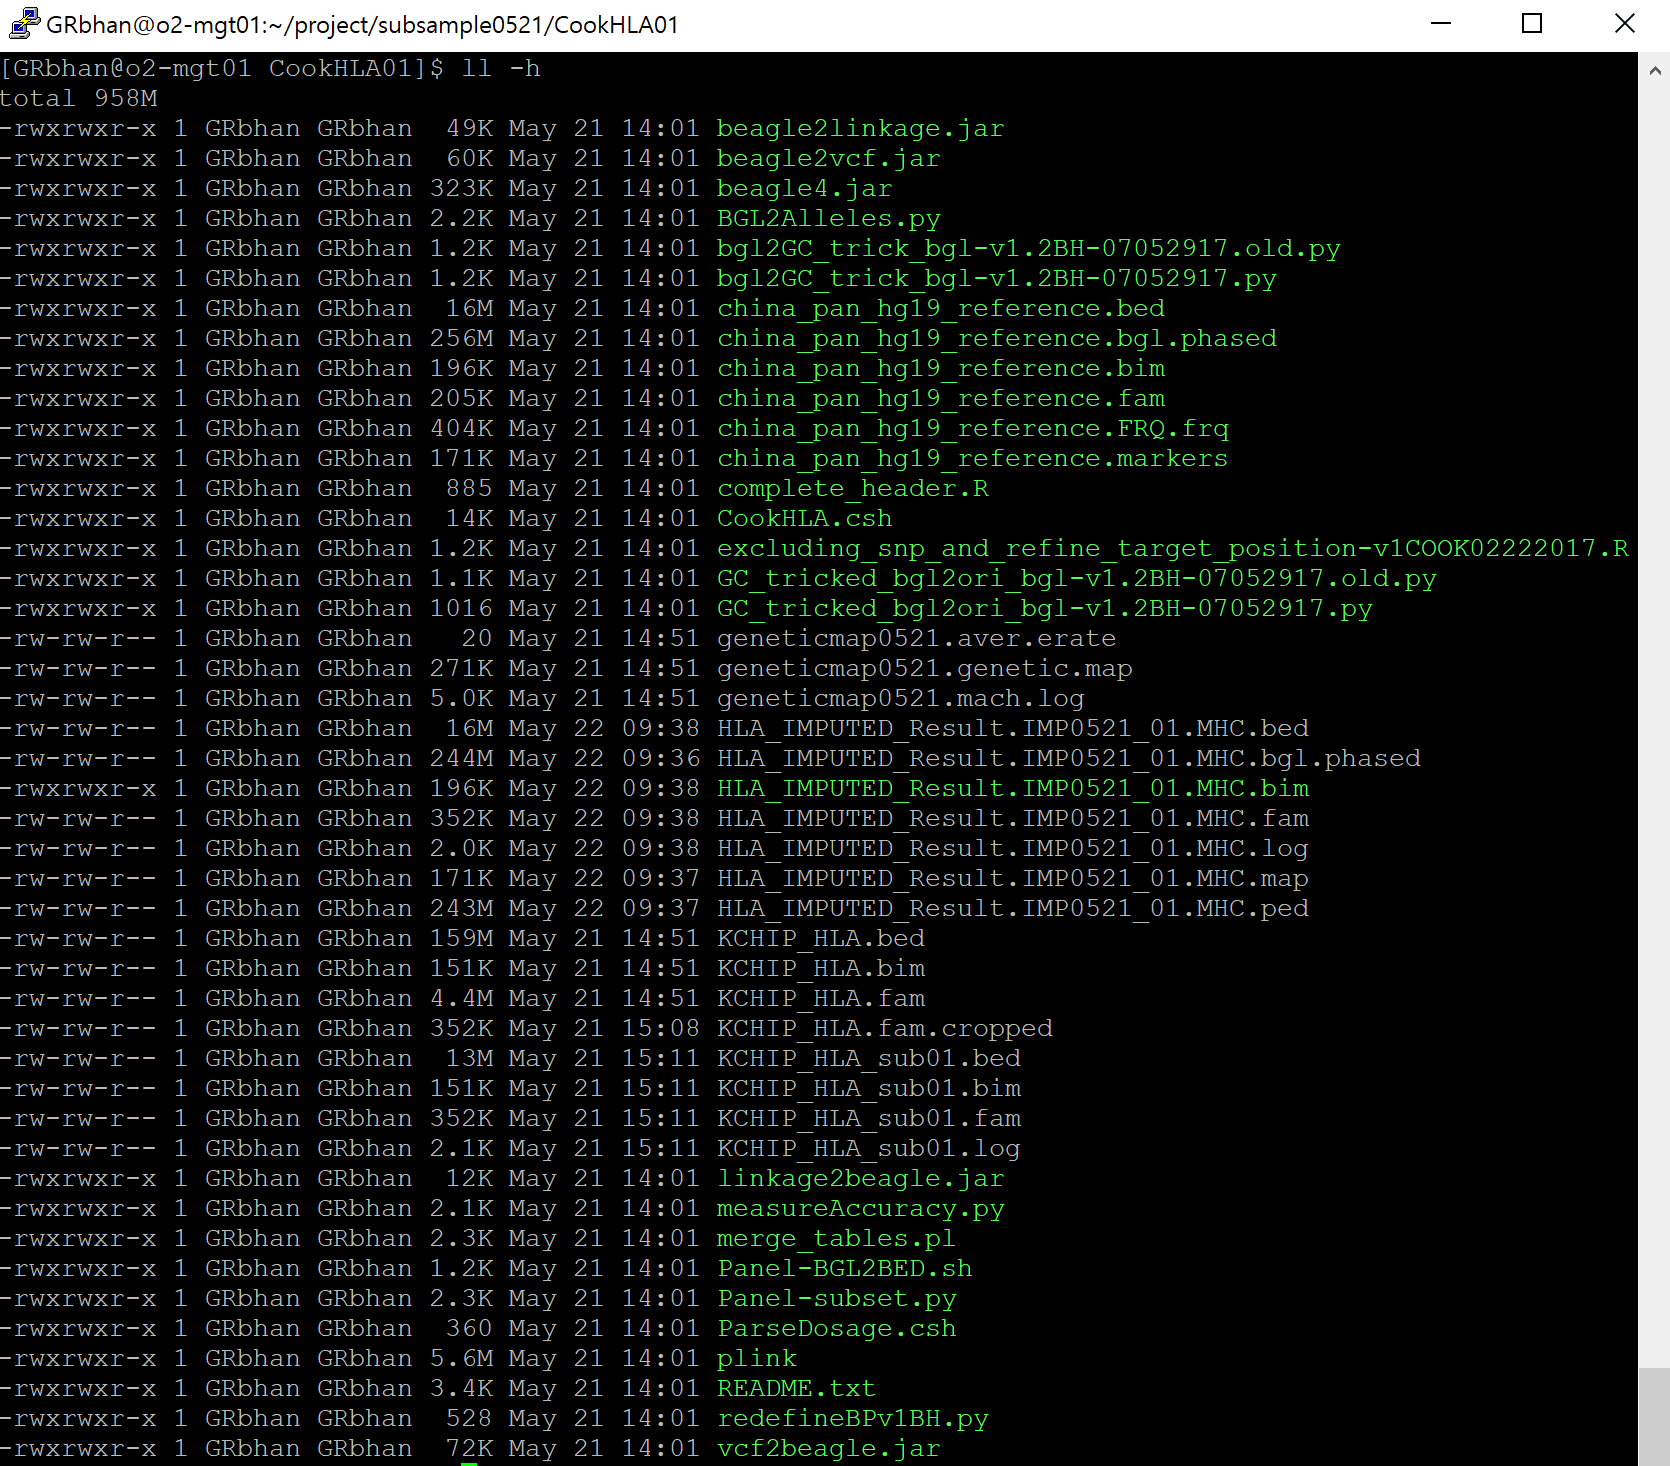

### all results( 'ls /CookHLA\*/HLA_IMPUTED\*')
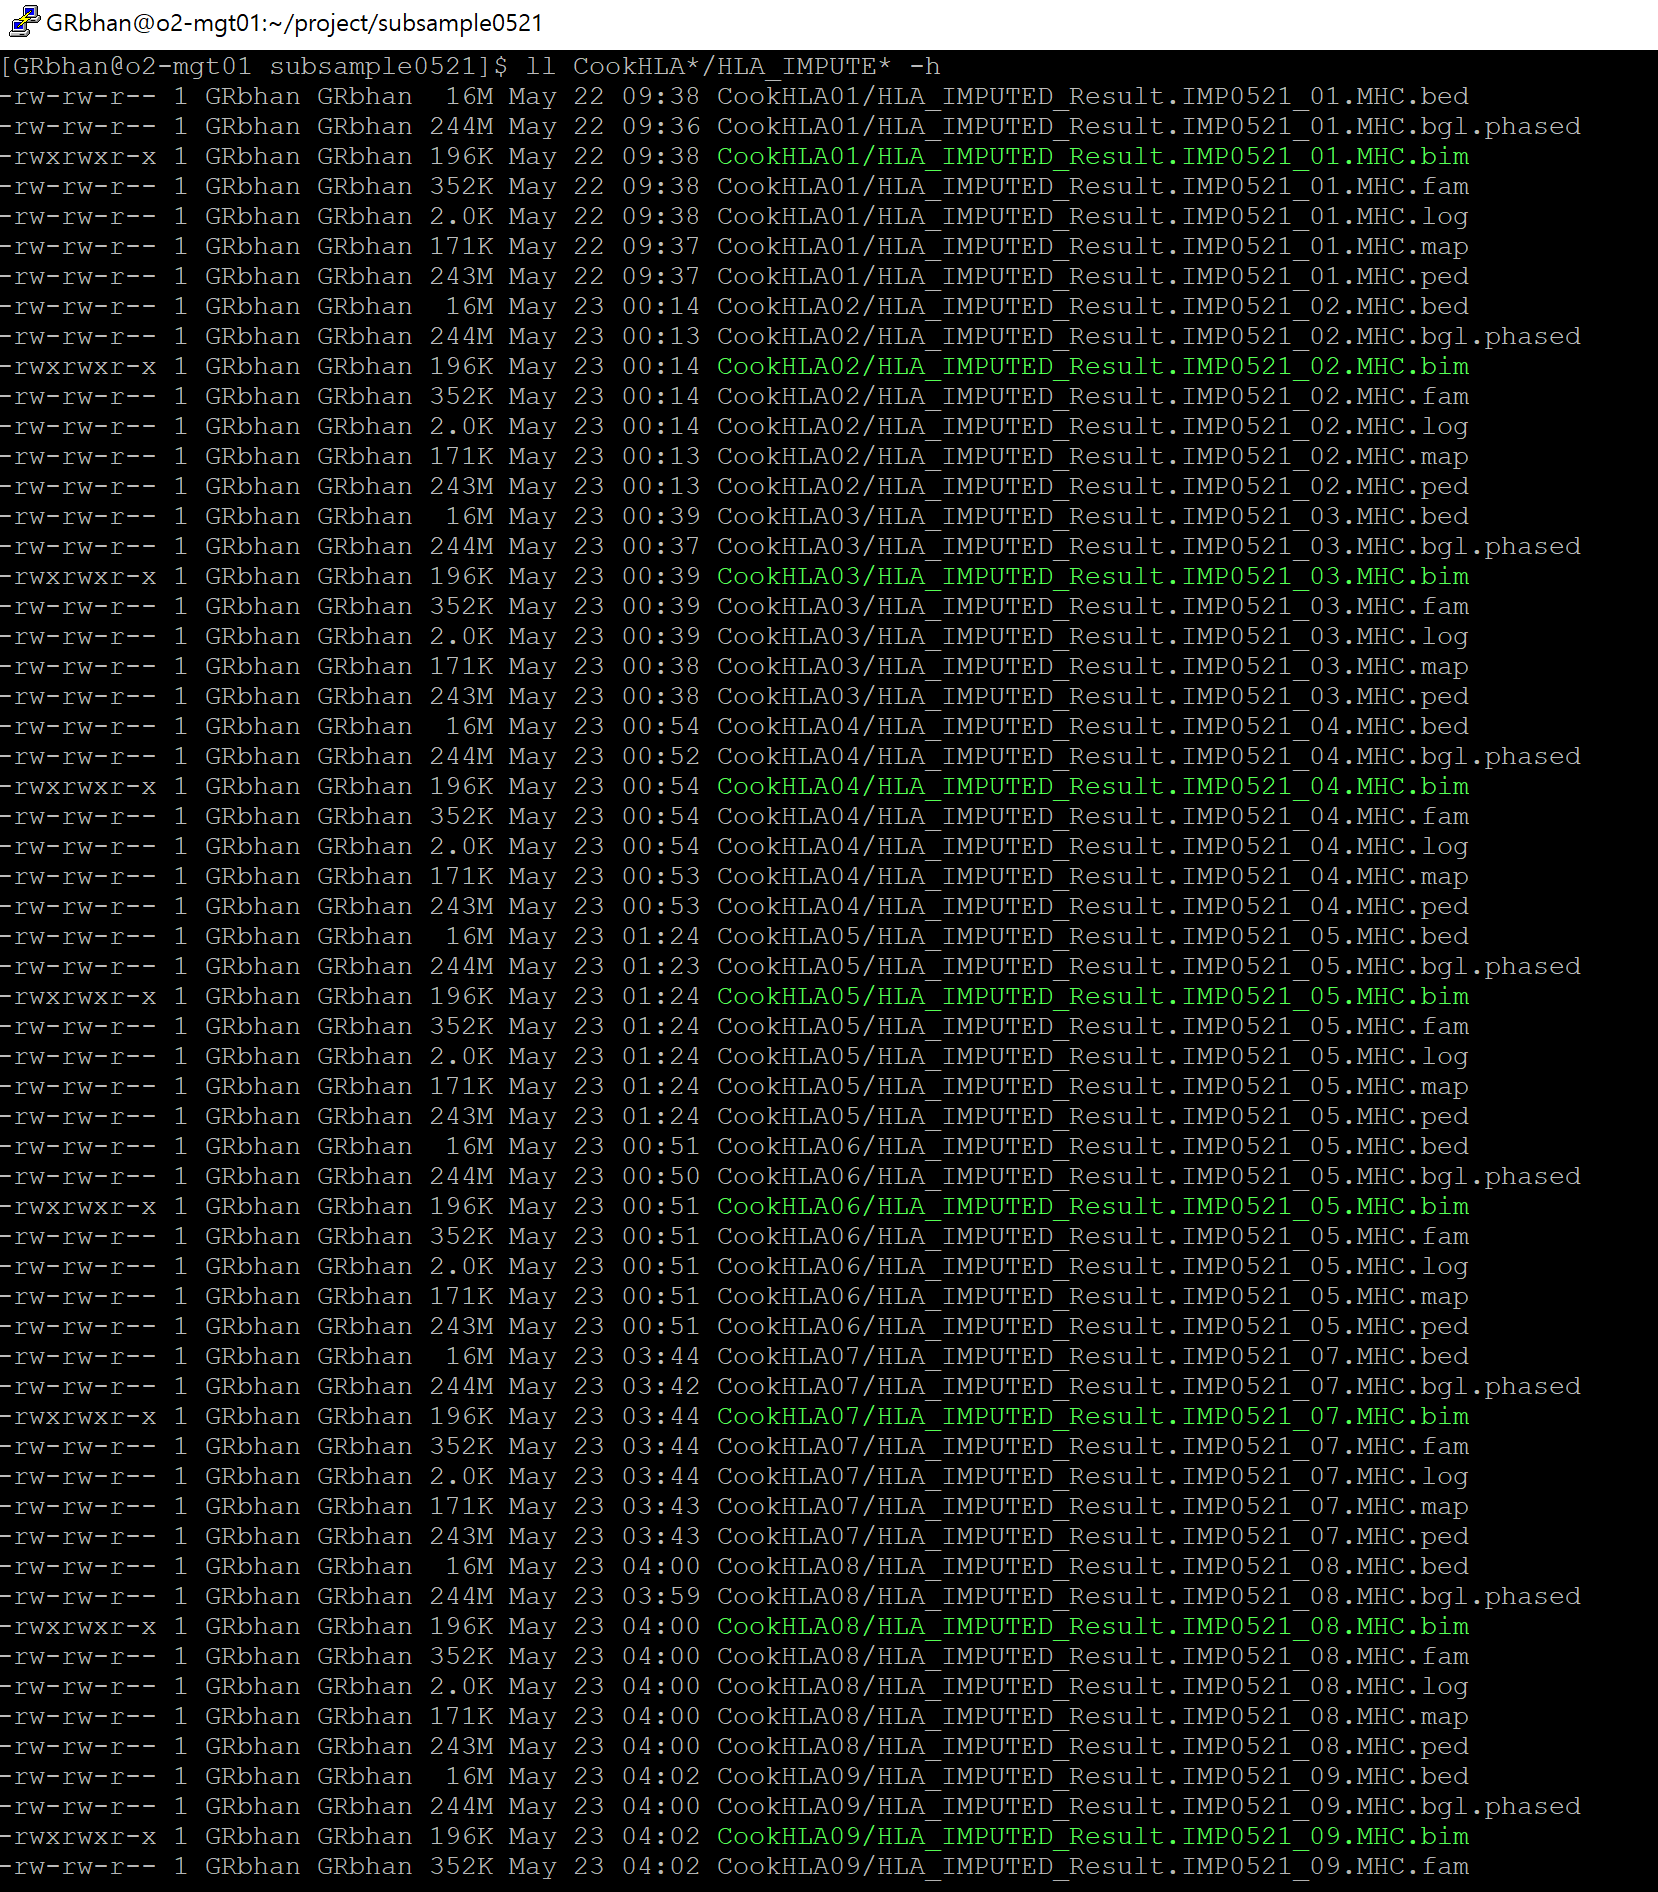

# Discussion

## subsample imputation 결과의 accuracy

Beagle 4.1 논문에 target sample가 각각 독립적으로 impute된다고 쓰여있습니다. 위 방법처럼 split하여 CookHLA를 하여도 accuracy에는 영향이 없을 것 같다는 추측이 듭니다.

> Because each target sample is imputed independently, computation time scales linearly in the number of target samples.

> Our imputation method groups together sets of consecutive genotyped markers that are within a fixed genetic distance. Because the number of aggregate genotyped markers in the target data increases more slowly than the number of genotyped markers, computation time increases sublinearly in the number of genotyped markers.

> Computation complexity is linear in the number of reference samples and linear in the number of reference markers. Doubling the number of reference samples typically also increases the number of non-monomorphic reference markers and thus results in a greater than 2-fold increase in computation time. However, if the number of potential reference markers is bounded, as is the case if insertion polymorphisms are ignored, then the growth in computation time will be asymptotically linear in the number of reference samples.

Genotype Imputation with Millions of Reference Samples, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4716681/

그러나, log의 DAG statistics이 약간 차이가 나서 걱정이 됩니다.<br>
모든 12만 sample에 대해 진행할 때와, 1만 subsample에 대해 진행할 때, edges/node는 1.03으로 비슷하나, edges/level은 5,000과 1,000으로 차이가 납니다. 대략 10배도 아니고, 5배의 애매한 숫자로 차이가 나서 걱정이 됩니다.

## Second Trial 실패 원인


[5 Third Trial(Success)](#another_cell)의 log를 참고해보면, 11~15iter가 1~10iter보다 10배정도 오래걸립니다. 이 비율에 따르면, Second trial에서 11번째 iter가 80시간(4일)이면 끝나야하는데, 이보다 훨씬 오래걸리고 있습니다. 아마 Beagle의 구조가 computing resource를 잘 이용하지 못하고 있는 것이 가장 큰 원인인 것 같습니다.

문제의 원인으로 OAS서버 OS의 resource 할당방식/서버의 하드웨어의 구조,설정/jvm의 특성/java와 OAS서버의 호환/일시적인 오류 등 다양한 원인이 있을 것 같습니다.<br>
OAS가 아닌 다른 일반적인 서버에서 CookHLA를 돌려본적이 없어서 정확한 원인은 모르겠지만, Beagle가 좋은 성능의 OAS 노드를 효율적으로 사용하지 못하고 있는 것 같습니다.

Second Trial의 Top에서 가상 메모리를 의미하는 VIRT는 500GB, 물리적 메모리를 의미하는 RES는 50G로 나왔습니다. Third Trial의 Top에서 가상 메모리를 의미하는 VIRT는 100GB, 물리적 메모리를 의미하는 RES는 50GB로 나왔습니다. VIRT에는 java 힙사이즈 파라미터로 준 값이 잘 나타나나, RES는 50GB로 동일하였습니다.<br>

제 생각에는 Second Trial의 샘플수가 많고, 실행한 node의 core수도 많아, 물리적메모리 사이즈도 크게 잡혀야 할 것 같은데, 그렇지 않습니다.
>Bealge 논문의 결과를 보면 memory per thread가 0.5GB~0.7GB로 core수에 비례하게 증가합니다.
>Beagle 4.1 논문의 supplementary material을 보면, 여러 크기의 refernce,target sample에 대해 benchmarking을 해두었는데,<br>
reference의 sample,marker과 target의 sample에 linear하게, target marker에는 sublinear하게 증가한다고 되어있습니다.

second trial에서 사용한 node의 core수는 36개이고, third trial에서 사용한 core수는 24개입니다. thread가 증가하여 총 메모리 usage가 늘어나는 것이 정상이나, 물리적메모리 사이즈가 50GB로 고정되어있습니다. thread별로 필요한 메모리 사이즈가 있는데, 이 사이즈가 제대로 할당되지 않아 문제가 발생하는 것 같습니다.

그러나, 또 CPU usage를 확인해보면 3600%로 겉보기에는 잘 작동하고 있는 것처럼 보입니다.
memory bottleneck이 발생하면, CPU usage가 1%로 떨어지는 것으로 알고 있습니다. 제가 아는 memory bottleneck확인법이 틀렸거나, top이 측정하는 CPU usage가 좀 다른 개념일 가능성도 있을 것 같습니다.



Beagle이 10만명 규모의 target에 대한 imputation에 대해 최적화되지 않았을 가능성이 있을 것 같습니다.<br>
논문에서 test된 set 중 가장 큰 규모가( target: n=1000, marker=3,333 / reference: n=200,000, marke=1,059,310 )입니다.
Beagle 4.1의 논문에서도 scalable reference sample에 대해서만 강조하고 있습니다.


### benchmarking result in Beagle 4.1 paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4716681/bin/mmc1.pdf

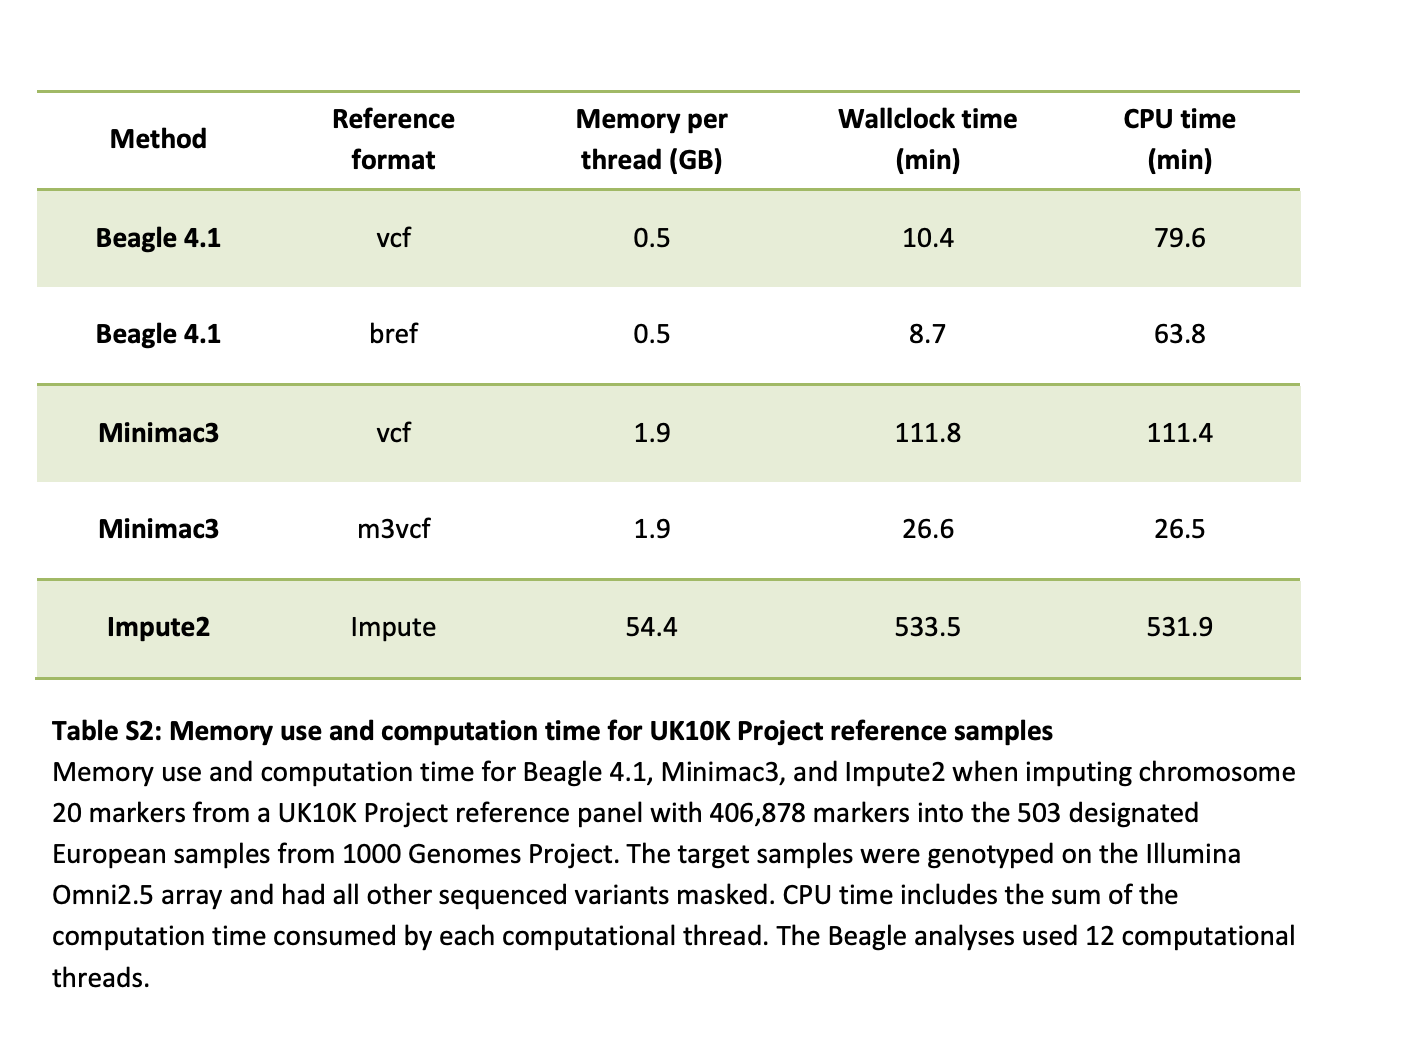

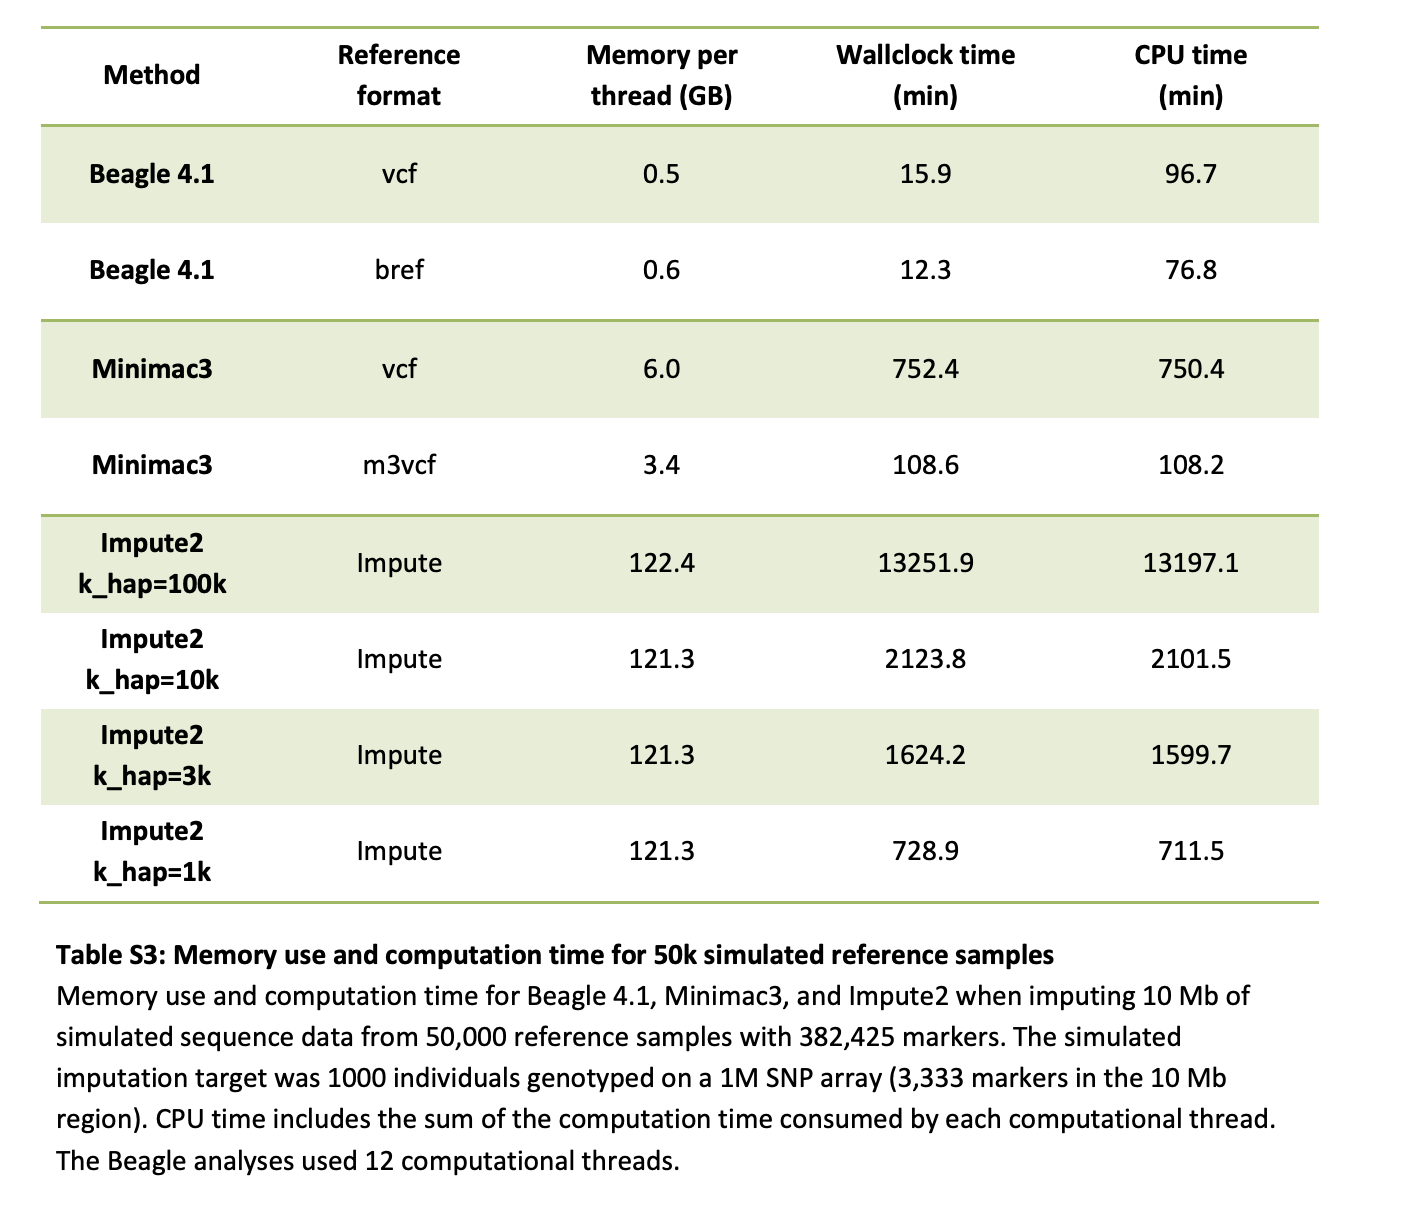

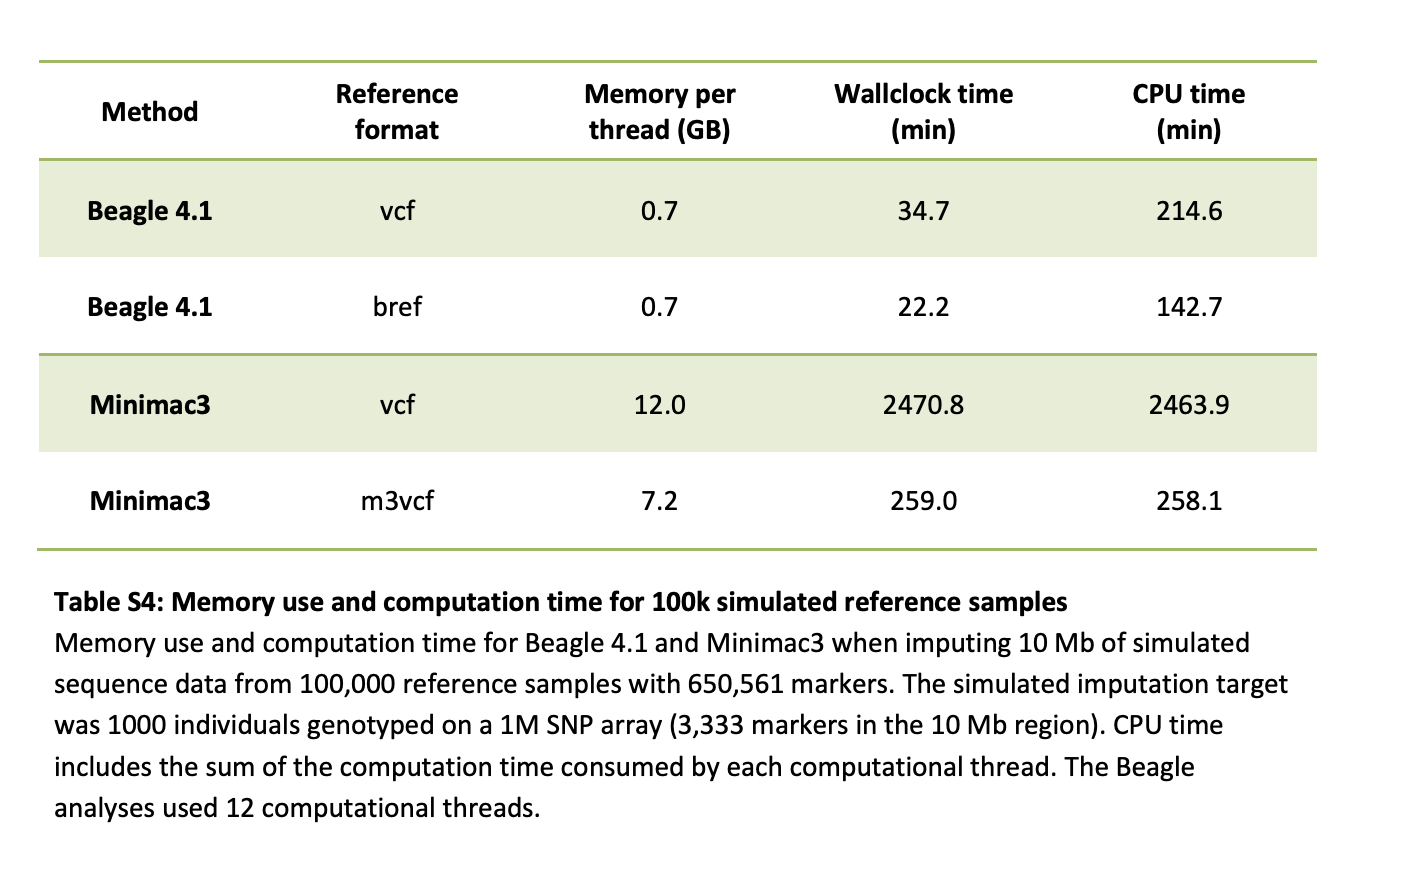

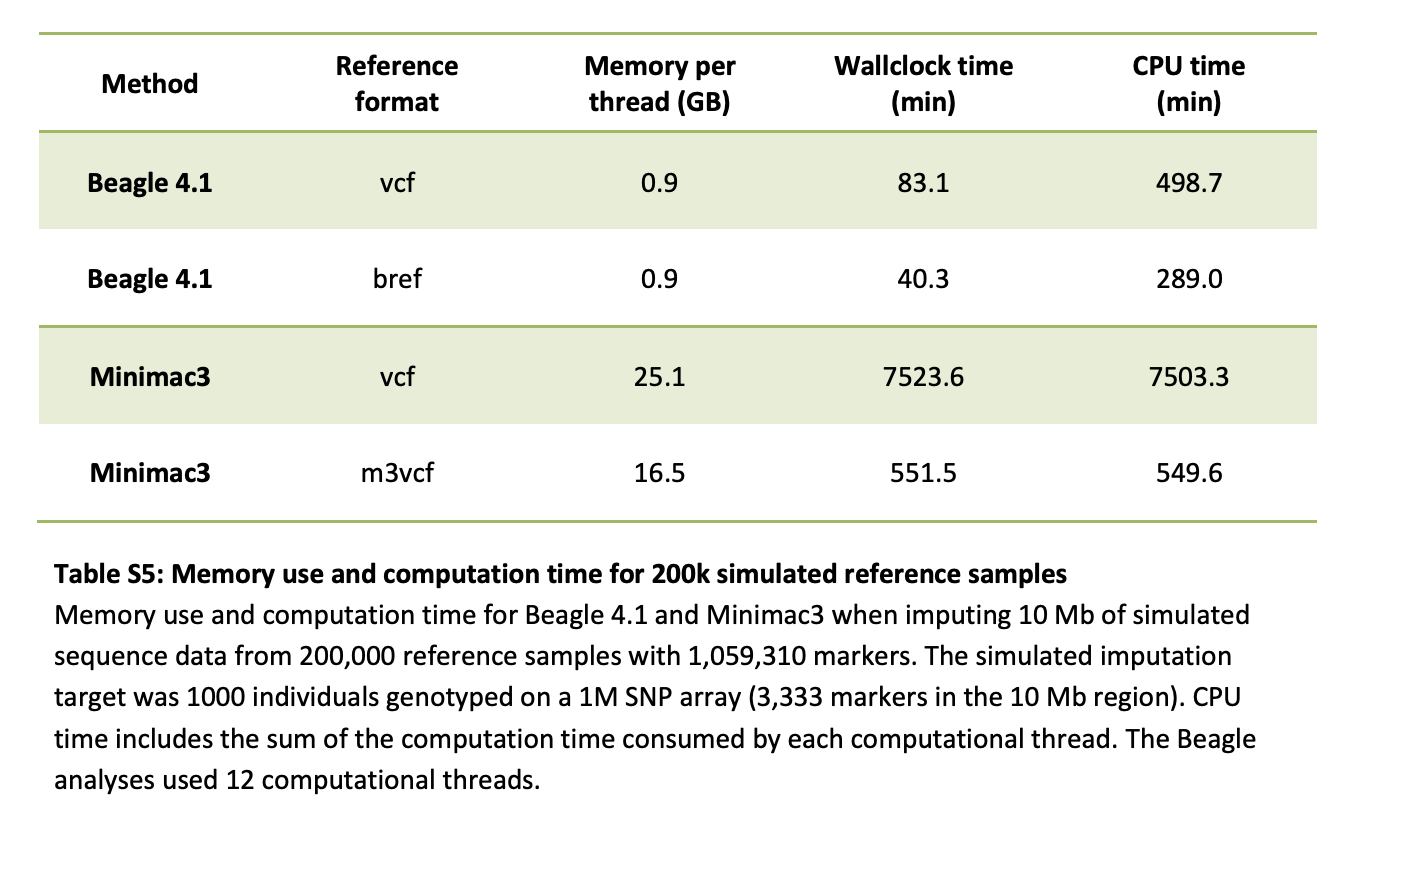